## Python import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf

from keras import layers
from keras import models
from keras import Input
from keras.models import Model
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, Dropout
from keras.utils import to_categorical
from keras import regularizers # L2규제

from tensorflow.keras.preprocessing.image import ImageDataGenerator # data augmentation
from tensorflow.keras.callbacks import LearningRateScheduler # callbacks 설정

from tqdm.notebook import tqdm # 모델학습 진행 시간 파악
import random # random seed를 뽑을때 사용

## Load Data

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

## EDA

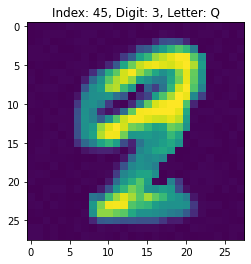

In [3]:
idx = 45
img = train.loc[idx, '0':].values.reshape(28, 28).astype(int)
digit = train.loc[idx, 'digit']
letter = train.loc[idx, 'letter']

plt.title('Index: %i, Digit: %s, Letter: %s'%(idx, digit, letter))
plt.imshow(img)
plt.show()

## Train model

In [4]:
x_train = train.drop(['id', 'digit', 'letter'], axis=1).values
x_train = x_train.reshape(-1, 28, 28, 1)
x_train = x_train/255

y = train['digit']
y_train = np.zeros((len(y), len(y.unique())))
for i, digit in enumerate(y):
    y_train[i, digit] = 1

In [5]:
def create_cnn_model():
    inputs = Input(shape = (28,28,1))
    
    bn = tf.keras.layers.BatchNormalization()(inputs)
    conv = tf.keras.layers.Conv2D(64, kernel_size=5, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(64, kernel_size=2, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    do=tf.keras.layers.Dropout(0.5)(conv)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(do)
    

    
    bn = tf.keras.layers.BatchNormalization()(pool)
    conv = tf.keras.layers.Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(128, kernel_size=2, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    do=tf.keras.layers.Dropout(0.5)(conv)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(do)

    
    
    bn = tf.keras.layers.BatchNormalization()(pool)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    do=tf.keras.layers.Dropout(0.5)(conv)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(do)

    flatten = tf.keras.layers.Flatten()(pool)

    bn = tf.keras.layers.BatchNormalization()(flatten)
    dense = tf.keras.layers.Dense(1000, activation='relu')(bn)

    bn = tf.keras.layers.BatchNormalization()(dense)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(bn)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [6]:
create_cnn_model().summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        1664      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        16448     
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0     

In [7]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

# 이미지 증식 사용
datagen = ImageDataGenerator(
  #  rotation_range=10,  
    zoom_range = 0.1, 
    width_shift_range=0.1,
    height_shift_range=0.1)

model = create_cnn_model()

#model.fit(x_train, y_train, epochs=50)

history = model.fit(
  datagen.flow(x_train, y_train, batch_size=16),
  epochs=200, 
  steps_per_epoch = x_train.shape[0]//16,
  callbacks=[annealer], 
  verbose = 1
)

Epoch 1/200
128/128 [==============================] - 14s 108ms/step - loss: 3.9132 - accuracy: 0.2153 - lr: 0.0010
Epoch 2/200
128/128 [==============================] - 14s 106ms/step - loss: 2.8974 - accuracy: 0.3203 - lr: 9.5000e-04
Epoch 3/200
128/128 [==============================] - 14s 106ms/step - loss: 2.5233 - accuracy: 0.4106 - lr: 9.0250e-04
Epoch 4/200
128/128 [==============================] - 13s 105ms/step - loss: 2.4396 - accuracy: 0.4429 - lr: 8.5737e-04
Epoch 5/200
128/128 [==============================] - 14s 106ms/step - loss: 2.2072 - accuracy: 0.5034 - lr: 8.1451e-04
Epoch 6/200
128/128 [==============================] - 14s 106ms/step - loss: 2.0617 - accuracy: 0.5405 - lr: 7.7378e-04
Epoch 7/200
128/128 [==============================] - 14s 106ms/step - loss: 1.9218 - accuracy: 0.5889 - lr: 7.3509e-04
Epoch 8/200
128/128 [==============================] - 14s 109ms/step - loss: 1.8526 - accuracy: 0.6123 - lr: 6.9834e-04
Epoch 9/200
128/128 [===============

Epoch 135/200
128/128 [==============================] - 14s 109ms/step - loss: 0.4361 - accuracy: 0.9741 - lr: 1.0351e-06
Epoch 136/200
128/128 [==============================] - 14s 109ms/step - loss: 0.4516 - accuracy: 0.9673 - lr: 9.8330e-07
Epoch 137/200
128/128 [==============================] - 14s 110ms/step - loss: 0.4480 - accuracy: 0.9712 - lr: 9.3414e-07
Epoch 138/200
128/128 [==============================] - 14s 110ms/step - loss: 0.4426 - accuracy: 0.9697 - lr: 8.8743e-07
Epoch 139/200
128/128 [==============================] - 14s 110ms/step - loss: 0.4342 - accuracy: 0.9683 - lr: 8.4306e-07
Epoch 140/200
128/128 [==============================] - 14s 110ms/step - loss: 0.4406 - accuracy: 0.9707 - lr: 8.0091e-07
Epoch 141/200
128/128 [==============================] - 14s 111ms/step - loss: 0.4432 - accuracy: 0.9712 - lr: 7.6086e-07
Epoch 142/200
128/128 [==============================] - 14s 111ms/step - loss: 0.4394 - accuracy: 0.9727 - lr: 7.2282e-07
Epoch 143/200
12

## Predict

In [8]:
x_test = test.drop(['id', 'letter'], axis=1).values
x_test = x_test.reshape(-1, 28, 28, 1)
x_test = x_test/255

submission = pd.read_csv('data/submission.csv')
submission['digit'] = np.argmax(model.predict(x_test), axis=1)
submission.head(50)

,id,digit
0,2049,6
1,2050,9
2,2051,6
3,2052,0
4,2053,3
5,2054,7
6,2055,5
7,2056,3
8,2057,4
9,2058,4


In [9]:
submission.to_csv('epoch100_한층 더쌓기_bn0.5위치변경_l2추가.csv', index=False)